In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
import joblib
from google.colab import drive
from google.colab import files

In [ ]:
# Drive
drive.mount('/content/drive')

#  dataset
base_path = '/content/drive/MyDrive/cv_project/Face Mask Dataset'
categories = ['WithMask', 'WithoutMask']
phases = ['Train', 'Validation', 'Test']

Mounted at /content/drive


In [ ]:
def display_samples(base_path, phase, category, n=3):
    folder_path = os.path.join(base_path, phase, category)
    files = os.listdir(folder_path)[:n]

    plt.figure(figsize=(15, 5))
    for i, file in enumerate(files):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"{category} Sample {i+1}")
        plt.axis('off')
    plt.show()


Sample images from the dataset:


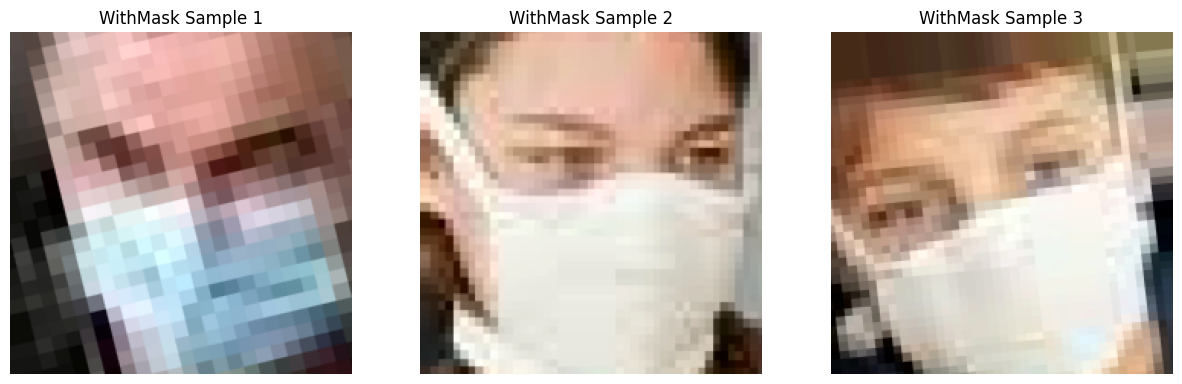

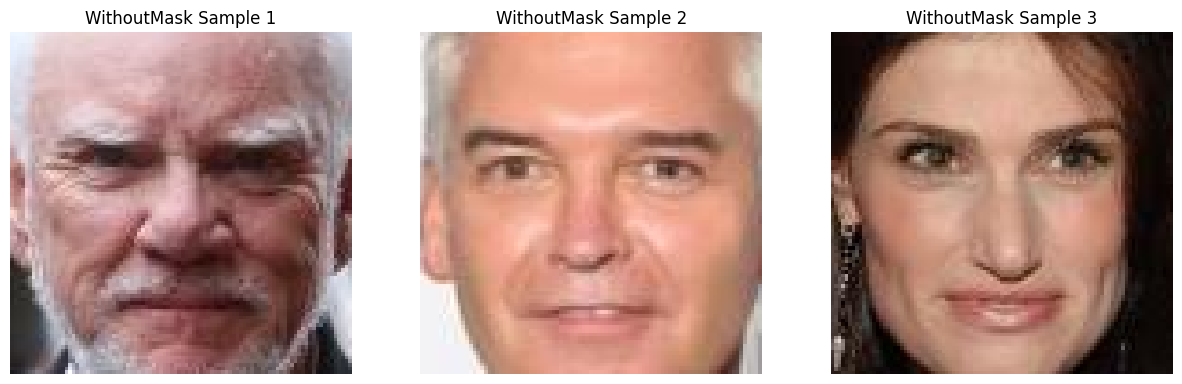

In [ ]:
print("Sample images from the dataset:")
display_samples(base_path, 'Train', 'WithMask', n=3)
display_samples(base_path, 'Train', 'WithoutMask', n=3)

In [ ]:
#  Sharpen filter
def sharpen_image(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)


In [ ]:
def show_image(title, image):
  plt.imshow(image, cmap='gray')
  plt.title(title)
  plt.axis('off')
  plt.show()


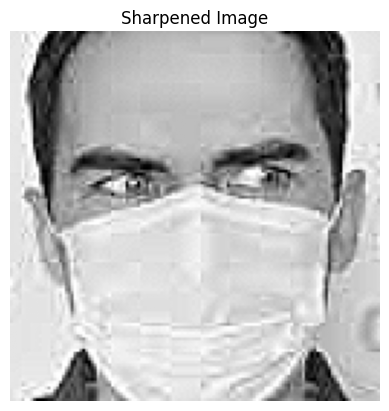

In [ ]:
img_path = '/content/drive/MyDrive/cv_project/Face Mask Dataset/Train/WithMask/119.png'
# Read and resize
img = cv2.imread(img_path)
img = cv2.resize(img, (128, 128))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply sharpen_image
sharpened = sharpen_image(gray)
show_image('Sharpened Image', sharpened)


In [ ]:
#  Simple segmentation by Otsu
def simple_segmentation(img):
    #  Otsu thresholding
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create empty mask
    mask = np.zeros_like(img)

    #  use only the largest contour
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    return cv2.bitwise_and(img, img, mask=mask)


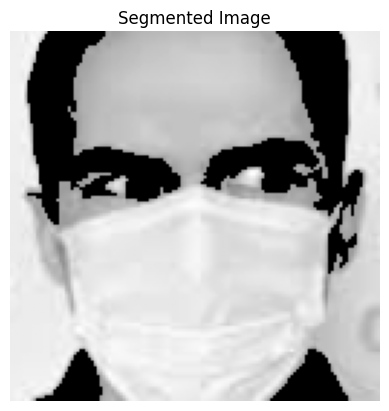

In [ ]:
# Apply simple segmentation
segmented = simple_segmentation(gray)
show_image('Segmented Image', segmented)


In [ ]:
#  Feature extraction using HOG
def extract_hog_features(img):
    winSize = (128, 128)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    return hog.compute(img).flatten()


In [ ]:
# Pipeline
def process_image_for_features(img_path):
    # Read the image
    img = cv2.imread(img_path)
    # Resize to 128x128
    img = cv2.resize(img, (128, 128))
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    # Sharpen
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    gray = cv2.filter2D(gray, -1, kernel)
    # Apply morphological opening
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel_open)
    # Apply segmentation with contour
    segmented = simple_segmentation(opened)
    # Compute HOG features
    hog_features = extract_hog_features(segmented)
    return hog_features

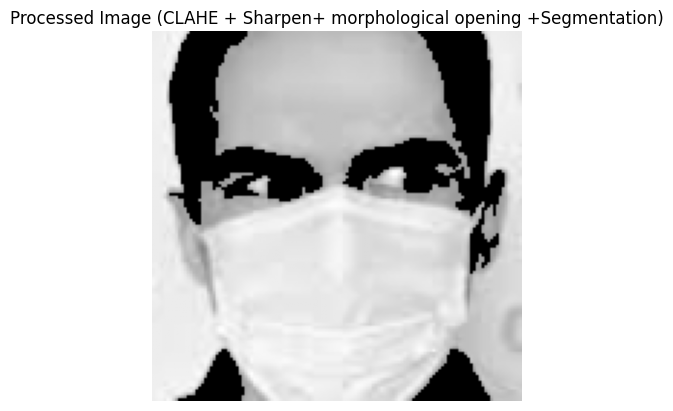

HOG Features shape: (8100,)
First 10 HOG feature values: [0.27153182 0.07637113 0.10139614 0.0654451  0.26593518 0.05577495
 0.03085351 0.03580263 0.27153182 0.27153182]


In [ ]:
# Apply process image for features
hog_features = process_image_for_features(img_path)
show_image('Processed Image (CLAHE + Sharpen+ morphological opening +Segmentation)', segmented)
# Print HOG feature vector shape
print(f'HOG Features shape: {hog_features.shape}')
print(f'First 10 HOG feature values: {hog_features[:10]}')

In [ ]:
# Collect features and labels
X_train, Y_train = [], []
X_val, Y_val = [], []
X_test, Y_test = [], []

for phase in phases:
    for label, category in enumerate(categories):
        folder_path = os.path.join(base_path, phase, category)
        files = os.listdir(folder_path)
        for img_file in files:
            img_path = os.path.join(folder_path, img_file)
            hog_features = process_image_for_features(img_path)
            if phase == 'Train':
                X_train.append(hog_features)
                Y_train.append(label)
            elif phase == 'Validation':
                X_val.append(hog_features)
                Y_val.append(label)
            else:
                X_test.append(hog_features)
                Y_test.append(label)


X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_model.fit(X_train_scaled, Y_train)

# Evaluate
val_accuracy = svm_model.score(X_val_scaled, Y_val)
test_accuracy = svm_model.score(X_test_scaled, Y_test)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save  scaler and model
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(svm_model, 'svm_model.pkl')

Validation Accuracy: 0.9600
Test Accuracy: 0.9657


['svm_model.pkl']

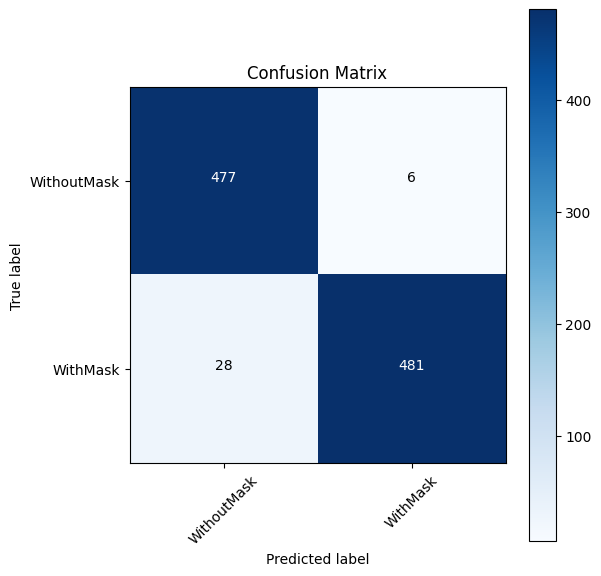

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Predict on test set
predictions = svm_model.predict(X_test_scaled)

# Plot confusion matrix
cm = confusion_matrix(Y_test, predictions)
classes = ['WithoutMask', 'WithMask']
plot_confusion_matrix(cm, classes)

Test Accuracy: 0.9657
Test Loss: 0.0343
Validation Accuracy: 0.9600
Validation Loss: 0.0400


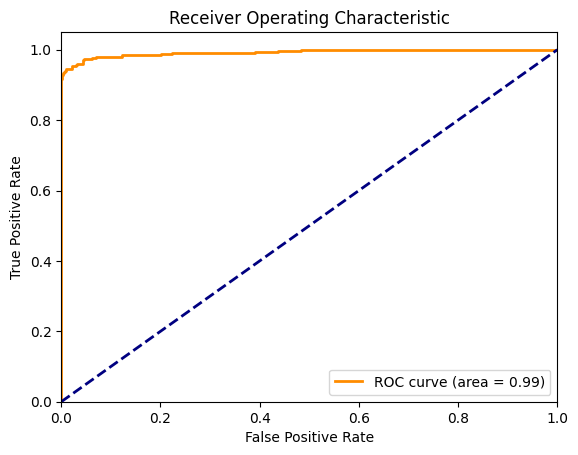

In [ ]:
# Test Accuracy and Loss
test_accuracy = svm_model.score(X_test_scaled, Y_test)
test_loss = 1 - test_accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Validation Accuracy and Loss
val_accuracy = svm_model.score(X_val_scaled, Y_val)
val_loss = 1 - val_accuracy
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# AUC Calculation
probs = svm_model.predict_proba(X_test_scaled)
probs_positive = probs[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, probs_positive)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Compute metrics for the test set
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

# Compute specificity (True Negative Rate)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# Compute balanced accuracy
balanced_accuracy = (recall + specificity) / 2

# Print  metrics
print("\nTest Set Classification Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(Y_test, predictions, target_names=classes))


Test Set Classification Metrics:
Precision: 0.9877
Recall (Sensitivity): 0.9450
F1 Score: 0.9659
Specificity: 0.9876
Balanced Accuracy: 0.9663

Classification Report:
              precision    recall  f1-score   support

 WithoutMask       0.94      0.99      0.97       483
    WithMask       0.99      0.94      0.97       509

    accuracy                           0.97       992
   macro avg       0.97      0.97      0.97       992
weighted avg       0.97      0.97      0.97       992



In [ ]:
# Load Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function processing image
def process_image(input_img, face_cascade, scaler, svm_model):
    gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    output_img = input_img.copy()
    labels_dict = {0: 'WithMask', 1: 'WithoutMask'}

    for (x, y, w, h) in faces:
        face_roi = input_img[y:y+h, x:x+w]
        face_resized = cv2.resize(face_roi, (128, 128))
        gray_face = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray_face = clahe.apply(gray_face)
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        gray_face = cv2.filter2D(gray_face, -1, kernel)
        kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        opened = cv2.morphologyEx(gray_face, cv2.MORPH_CLOSE, kernel_open)
        segmented = simple_segmentation(opened)
        hog_features = extract_hog_features(segmented)
        hog_features_scaled = scaler.transform([hog_features])

        pred = svm_model.predict(hog_features_scaled)[0]
        print("Prediction:", pred)

        label = labels_dict[pred]

        color = (0, 255, 0) if pred == 0 else (0, 0, 255)
        cv2.rectangle(output_img, (x, y), (x+w, y+h), color, 2)
        cv2.putText(output_img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        return output_img

In [ ]:
import joblib

# save model
joblib.dump(svm_model, 'svm_model_sample_segmentation.pkl')

# save scaler
joblib.dump(scaler, 'scaler_sample_segmentation.pkl')

['scaler_sample_segmentation.pkl']

In [ ]:
svm_model = joblib.load('svm_model.pkl')
scaler = joblib.load('scaler.pkl')

In [ ]:
from google.colab import files
files.download('svm_model.pkl')
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import joblib

In [ ]:
# Load the model and scaler
svm_model = joblib.load('/content/svm_model_sample_segmentation.pkl')
scaler = joblib.load('/content/scaler_sample_segmentation.pkl')

In [ ]:
# Load Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

#  Simple segmentation by Otsu
def simple_segmentation(img):
    #  Otsu thresholding
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Create empty mask
    mask = np.zeros_like(img)
    #  use only the largest contour
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    return cv2.bitwise_and(img, img, mask=mask)

# HOG feature extractor
def extract_hog_features(img):
    winSize = (128, 128)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    return hog.compute(img).flatten()

In [ ]:
# Image processing and prediction
def detect_and_classify(image):
    input_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    labels_dict = {0: 'WithMask', 1: 'WithoutMask'}
    output_img = input_img.copy()

    for (x, y, w, h) in faces:
        face_roi = input_img[y:y+h, x:x+w]
        face_resized = cv2.resize(face_roi, (128, 128))
        gray_face = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray_face = clahe.apply(gray_face)
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        gray_face = cv2.filter2D(gray_face, -1, kernel)
        kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        opened = cv2.morphologyEx(gray_face, cv2.MORPH_CLOSE, kernel_open)
        segmented = simple_segmentation(opened)
        hog_features = extract_hog_features(segmented)

        hog_features_scaled = scaler.transform([hog_features])
        pred = svm_model.predict(hog_features_scaled)[0]
        label = labels_dict[pred]
        color = (0, 255, 0) if pred == 0 else (0, 0, 255)

        cv2.rectangle(output_img, (x, y), (x+w, y+h), color, 2)
        cv2.putText(output_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    return cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

In [ ]:
# Launch Gradio app
gr.Interface(
    fn=detect_and_classify,
    inputs=gr.Image(type="numpy", label="Upload an image"),
    outputs=gr.Image(type="numpy", label="Output with bounding boxes"),
    title="Face Mask Detection (SVM + HOG)",
    description="Upload a photo to detect faces and classify mask presence."
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fd8c232e1eb9c8890c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
